## 1. XGBoost: Fast Results with Explainability

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from dataset import RentingRegressionDataset

In [5]:
df = pd.read_csv('data/lat_long_preprocessed_data.csv')

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Fit the one hot encoder to the training data so the dataset can be encoded
type_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
type_encoder.fit(train_df[['Type']])

# Create the datasets
train_dataset = RentingRegressionDataset(train_df, type_encoder, is_train=True)
test_dataset = RentingRegressionDataset(test_df, type_encoder, is_train=False)

Convert the datasets to NumPy arrays to work with XGBoost:

In [8]:
def dataset_to_numpy(dataset):
    features, targets = [], []
    for i in range(len(dataset)):
        feature, target = dataset[i]
        features.append(feature.numpy())
        targets.append(target.item())
    return np.array(features), np.array(targets)

In [9]:
X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

Initialize XGBoost model:

In [57]:
model = xgb.XGBRegressor(
            objective='reg:squarederror',
            colsample_bytree=0.3,
            learning_rate=0.1,
            max_depth=5,
            alpha=10,
            n_estimators=1000, # 100
            reg_lambda=1,
)

Train the model:

In [58]:
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [59]:
predictions = model.predict(X_test)

In [60]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

In [61]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 378.6786848220314
Mean Squared Error (MSE): 483387.4789773974
Root Mean Squared Error (RMSE): 695.2607273371605
R-squared (R²): 0.8604087895489123


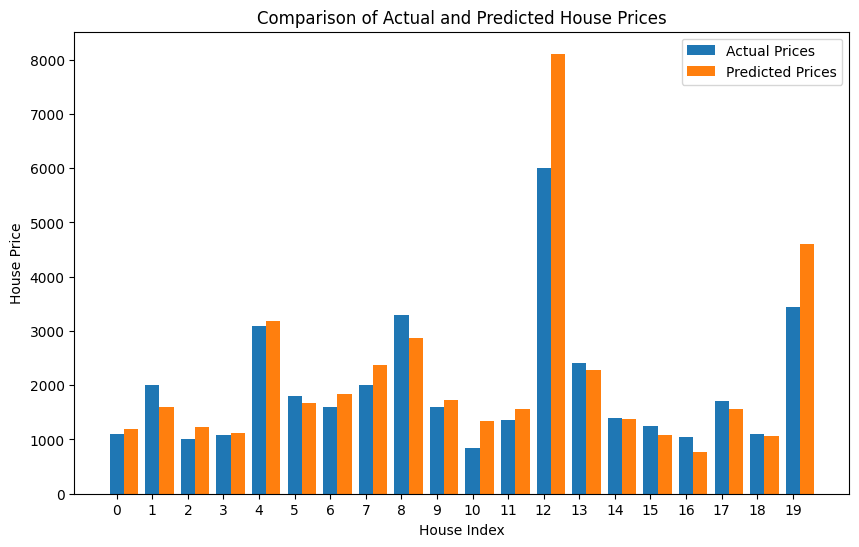

In [74]:
num_houses_to_plot = 20

plt.figure(figsize=(10, 6))
plt.title("Comparison of Actual and Predicted House Prices")
plt.xlabel("House Index")
plt.ylabel("House Price")
plt.xticks(np.arange(num_houses_to_plot))
bar_width = 0.4
plt.bar(np.arange(num_houses_to_plot), y_test[:num_houses_to_plot], width=bar_width, label="Actual Prices")
plt.bar(np.arange(num_houses_to_plot) + bar_width, predictions[:num_houses_to_plot], width=bar_width, label="Predicted Prices")

plt.legend()
plt.show()

## 2. Transformer with Explainability: Great Results but with a less interpretable model

In [ ]:
from pytorch_lightning import Trainer
import torch